In [53]:
import csv
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers import Convolution2D
from sklearn.model_selection import train_test_split

In [44]:
lines =[]
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
images =[]
measurements = []
for line in lines:
    source_path = line[0]
    filename = source_path.split('/')[-1]
    current_path = 'data/IMG/' +filename
    image = cv2.imread(current_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)

X_train = np.array(images)
y_train = np.array(measurements)


In [3]:
def preprocess(img):
    new_images =[]
    numOfImage = len(img)
    for i in range(0, numOfImage):
        img1 = img[i]
        new_img = cv2.cvtColor(img1, cv2.COLOR_BGR2YUV)
        new_images.append(new_img)
    
    new_images = np.array(new_images)
    return new_images

In [39]:
def addFlippedData(images, measurements):
    flipped_images, flipped_measurements = [],[]
  
    for image, measurement in zip(images, measurements):
        flipped_images.append(image)
        flipped_measurements.append(measurement)
        flipped_images.append(cv2.flip(image, 1))
        flipped_measurements.append(measurement * -1.0)
        
    X_augmented = np.array(flipped_images)
    y_augmented = np.array(flipped_measurements)
    return X_augmented, y_augmented

In [4]:

X_train_proc = preprocess(X_train)

In [40]:
X_augmented, y_augmented = addFlippedData(X_train_proc, y_train)

In [5]:
import sklearn
def splitData(features, labels, splitRatio =0.2):

    X_train, X_validation, y_train, y_validation = train_test_split(features, labels, test_size = splitRatio)
    trainSet =[X_train, y_train]
    validationSet = [X_validation, y_validation]

    return trainSet, validationSet
    


In [56]:
model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: (x/255.0)- 0.5))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

In [57]:
def generator(samples, batch_size):
 # Create empty arrays to contain batch of features and labels#
    numFeatures = len(samples[0])
    rowLen = np.shape(trainSet[0])[1]
    colLen = np.shape(trainSet[0])[2]
    batch_features = np.zeros((batch_size, rowLen, colLen, 3))
    batch_labels = np.zeros((batch_size,1))
    while True:
        for offset in range(0, numFeatures, batch_size):
            endIndex = min(offset+ batch_size, numFeatures)
            batch_features = (samples[0][offset:endIndex])
            batch_labels = (samples[1][offset:endIndex])

            yield [batch_features, batch_labels]

160

In [42]:
trainSet, validationSet = splitData(X_augmented,y_augmented)


In [58]:

batch_size = 32
numTrain = len(trainSet[0])
numValidation = len(validationSet[0])
train_generator = generator(trainSet, batch_size)
validation_generator = generator(validationSet, batch_size)
model.compile(loss='mse', optimizer ='adam')
#model.fit(X_train_proc, y_train, validation_split =0.2, shuffle = True)
model_history = model.fit_generator(train_generator, samples_per_epoch=numTrain, nb_epoch=3)
model.save('model.h5')

Epoch 1/3
46622/46622 [==============================] - 34s - loss: 0.0015    
Epoch 2/3
46622/46622 [==============================] - 34s - loss: 9.4037e-04    
Epoch 3/3
46622/46622 [==============================] - 34s - loss: 7.7637e-04    


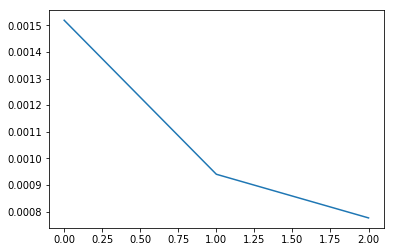

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(model_history.history['loss'])
